
# OTT-jax tutorial : on the Pooladian and Niles-Weedto estimator of optimal transport maps.


## 0. Soft prerequisites



### 0.1. Installation

In [100]:
! pip install ott-jax

### 0.2 Libraries and modules

In [101]:
# Import necessary libraries
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.linalg import inv,det,sqrtm,cholesky, solve_triangular,eigh
from jax.scipy.stats import multivariate_normal
from jax import vmap

 # to compute optimal transport between gaussians,pdfs

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn


import numpy as np
import matplotlib.pyplot as plt
from ott.geometry import pointcloud
#from ott.core import sinkhorn
#from ott.core import sinkhorn
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2


from tensorflow_probability.substrates import jax as tfp# for multinomial


### 0.3 Toggle to test functions

In [102]:
test=False

## 1. Theory



In this notebook we present the estimator of the optimal transport betwenn distributions of Pooladian
and Niles-Weedto as described in their [paper](https://arxiv.org/abs/2109.12004). For the sake of consistency, we borrowed their notations and some of their formulations.

### 1.1. General formulation of the problem of estimating the optimal transport between two distributions from a sample.

#### 1.1.1 The optimal transport problem (Monge, 1781)


Let $P$ and $Q$ are two probability measures on the measureable space $(\Omega,\mathscr{A})$, where $\Omega \subseteq \mathbb{R}^d$, $d\geq 1$ and $\mathscr{A}:=\{A\cap\Omega,A\in\mathrm{Borel}(\mathbb{R}^d)\}$, $\mathrm{Borel}(\mathbb{R}^d)$ is the Borel $\sigma$-field on $\mathbb{R}^d$.

We denote by  $\mathcal{T}(P,Q)$ is the set of *admissible maps*, defined as

$$\mathcal{T}(P,Q) := \{T \in \Omega^\Omega :   T\text{ is }((\Omega,\mathscr{A}),(\Omega,\mathscr{A}))\text{-measurable and }P^T = Q\},$$ where $P^T$ is the probability measure : $P^T:\mathscr{A}\to[0,1], A\mapsto P(T^{-1}(A))$.

An optimal transport from $P$ to $Q$ for the  cost function: $c:\Omega^2\to[0,\infty),(x,y)\mapsto c(x,y)=\|x-y\|^2_2$ is an element $T_0$ of

$$\underset{T \in \mathcal{T}(P,Q)}{\mathrm{argmin}} \left\{\int c( x,  T(x)) ~\mathrm{d}P(x)\right\},      
 ~~~~~~~~~(1)$$
when this set is not empty. In the following, we will not consider other cost function.


#### 1.1.2 Examples : gaussian distributions
In this section we provide some examples of distributions for which we can compute the optimal transport. It will prove handy later to study the properties of the estimators of the optimal transport from samples of the distributions $P$ and $Q$.


Suppose  $P=\mathrm{Normal}(\mu_0,\Sigma_0)$, $Q=\mathrm{Normal}(\mu_1,\Sigma_1)$ then there exist a solution to the optimal transport problem of Equation (1): $$T(x) = \mu_1 + (\Sigma_0^{-1/2}(\Sigma_0^{1/2}\Sigma_1 \Sigma_0^{1/2})^{1/2} \Sigma_0^{-1/2})(x-\mu_0).$$


#### Code :  distribution class and functions to plot

In [103]:


def multinomial(key, n, p, shape=()):
    return tfp.distributions.Multinomial(n, probs=p).sample(
        seed=key,
        sample_shape=shape,)
class gaussian_mixture_distribution:
    def __init__(self,
                means,
                sigmas,
                mixing_coefficients=None):
        """

        Args:
          means shape: (n_components, n_dimensions)
          sigmas shape: (n_components, n_dimensions, n_dimensions)
          mixing_coefficients: (n components)
        """
        self.means           = means
        self.sigmas          = sigmas
        self.i               = self.means.shape[0]
        self.space_dimension = self.means.shape[1]
        if mixing_coefficients is None:
            self.mixing_coefficients=mixing_coefficients
            self.mix = jnp.full(self.i, 1/self.i)
        else:
          self.mixing_coefficients=mixing_coefficients
          self.mix=mixing_coefficients/jnp.sum(mixing_coefficients)
        # Define the probability density function (pdf) for the mixture model
        #return sum(self.mix[j] * np.array([multivariate_normal.pdf(points[:,k], mean=means[j,:], cov=sigmas[j,:,:]) for k in range(points.shape[1])]) for j in range(self.i))

    def pdf(self,points):
        """Evaluate the PDF of a mixture of Gaussians at each point."""
        # Define a function to calculate PDF using the logpdf method
        def logpdf_mv_normal(x, mean, sigma):
            """Compute log PDF of a multivariate normal distribution."""
            n = mean.shape[0]
            L = cholesky(sigma)
            y = solve_triangular(L, (x - mean), lower=True)
            logdet = 2 * jnp.sum(jnp.log(jnp.diag(L)))
            return -0.5 * n * jnp.log(2 * jnp.pi) - 0.5 * logdet - 0.5 * jnp.dot(y, y)
        def pdf_single_component(point, mean, sigma):
            """Compute PDF by exponentiating the log PDF."""
            return jnp.exp(logpdf_mv_normal(point, mean, sigma))


        def pdf_single_component1(point, mean, sigma):
        # mean shape: (n_dimensions)
        # sigma shape: (n_dimensions, n_dimensions)
            return jnp.exp(multivariate_normal.logpdf(point, mean, sigma))

        # Vectorize the PDF computation over both points and mixture components
        # points shape: (n_points, n_dimensions)
        pdf_all_components = vmap(vmap(pdf_single_component, in_axes=(0, None, None)), in_axes=(None, 0, 0))
        component_pdf =      vmap(vmap(pdf_single_component, in_axes=(0, None, None)), in_axes=(None, 0, 0))
        pdf_values = component_pdf(points, self.means, self.sigmas)
        # Weight PDFs by their mixing coefficients and sum across components
        weighted_pdf_values = jnp.tensordot(pdf_values, self.mix, axes=[0, 0])
        print("pdf_values")
        print(pdf_values)
        return weighted_pdf_values

    def sample(self, key,n_samples):
        component_samples = []
        # Split the key for initial counts and then additional keys for sampling
        keys = random.split(key, num=self.i + 1)
        counts = multinomial(keys[0], n=n_samples, p=self.mix,shape=[1])
        for i in range(self.i):
            if counts[0,i].item() > 0:  # Only sample if there are samples to draw
                samples_from_component = random.multivariate_normal(keys[i+1], mean=self.means[i, :],
                                                                    cov=self.sigmas[i, :, :],
                                                                    shape=(int(counts[0,i].item()),))
        component_samples.append(samples_from_component)
        # Concatenate all samples
        all_samples = jnp.vstack(component_samples)
        # Shuffle to mix the samples from different components
        #all_samples = jax.random.permutation(keys[-1], all_samples)
        return all_samples



    def range(self):
      r = jnp.zeros([self.space_dimension, 2])
      # Using .at[].set() to immutably modify the array
      r = r.at[:, 0].set(self.means[0, :])
      r = r.at[:, 1].set(self.means[0, :])
      for i in range(self.means.shape[0]):
            for j in range(self.space_dimension):
                r = r.at[j, 0].set(jnp.minimum(r[j, 0], self.means[i, j]-3*jnp.sqrt(self.sigmas[i,j,j])))
                r = r.at[j, 1].set(jnp.maximum(r[j, 1], self.means[i, j]+3*jnp.sqrt(self.sigmas[i,j,j])))
      return r
#test
if test:
  def generate_positive_definite_matrices(key, n_components=3, n_dimensions=4):
    # Generate a random key for JAX
    keys = random.split(key, n_components)
    # Create an array to store the matrices
    matrices = jnp.zeros((n_components, n_dimensions, n_dimensions))
    for i, key in enumerate(keys):
        # Generate a random matrix
        A = random.normal(key, (n_dimensions, n_dimensions))
        # Make the matrix symmetric
        A_symmetric =A @ A.T
        # Make the matrix positive definite
        A_pos_def = A_symmetric + n_dimensions* jnp.eye(n_dimensions)
        # Store the matrix in the array
        matrices = matrices.at[i].set(A_pos_def)
    return matrices

  def test0(n_dimensions,n_points,n_components,key):
    ### 1D example with a mix of two distributions
    mixing_coefficients_d=jnp.array(np.random.randn(n_components))
    means_d=jnp.array(np.random.randn(n_components, n_dimensions))
    sigmas_d=generate_positive_definite_matrices(key,n_components, n_dimensions)
    points = jnp.array(np.random.randn(n_points, n_dimensions))
    dist_d=gaussian_mixture_distribution(means=means_d,sigmas=sigmas_d,mixing_coefficients=mixing_coefficients_d)
    print("- sigmas:")
    print(sigmas_d)
    print("- density:")
    print(dist_d.pdf(jnp.array(points)))
    print("- range:")
    print(dist_d.range())
    print("- sample:")
    print(dist_d.sample(key,3))

  key = random.PRNGKey(0)
  print(generate_positive_definite_matrices(key,3,2))
  print("1d")
  test0(1,2,3,key)
  print("2d")
  test0(2,3,4,key)




In [104]:
import jax.numpy as jnp

# Example jnp array
x = jnp.array([[[1, 2], [3, 4], [5, 6]],
               [[7, 8], [9, 10], [11, 12]]])

# Indexing with drop=False
result = x[0,  jnp.newaxis,:]  # Add a new axis to keep the dimensionality unchanged
print(x.shape)
print(result.shape)

(2, 3, 2)
(1, 3, 2)


In [105]:
def optimal_transport_gaussian(gaussian1,gaussian2):

    mu0, Sigma0, mu1, Sigma1 =  (gaussian1.means[0,:], gaussian1.sigmas[0,:,:],gaussian2.means[0,:], gaussian2.sigmas[0,:,:])

    # Compute necessary matrix square roots and inversions
    Sigma0_half = sqrtm(Sigma0)
    Sigma0_inv_half = jnp.linalg.inv(Sigma0_half)
    M = Sigma0_half @ Sigma1 @ Sigma0_half
    M_half = sqrtm(M)
    M_inv_half = jnp.linalg.inv(M_half)

    # Compute the optimal transformation matrix B
    B = jnp.real(Sigma0_inv_half @ M_half @ Sigma0_inv_half)

    # Define the transport function
    def make_transport(mu0, mu1, B):
        def transport(x):
           return jnp.real(mu1 + jnp.dot(B, (x - mu0)))
        return transport
    transport = make_transport(mu0, mu1, B)
    return vmap(transport,in_axes=0)
#test
if test:
    def generate_2_gaussians(n_dimensions,key):
        means_d=jnp.array(np.random.randn(2, n_dimensions))
        sigmas_d=generate_positive_definite_matrices(key,2, n_dimensions)
        gaussian1=gaussian_mixture_distribution(means_d[0,:][jnp.newaxis,:],sigmas_d[0,:,:][jnp.newaxis,:,:])
        gaussian2=gaussian_mixture_distribution(means_d[1,:][jnp.newaxis,:],sigmas_d[1,:,:][jnp.newaxis,:,:])
        return [gaussian1,gaussian2]

    def test1(n_dimensions,key):
        ### 1D example with a mix of two distributions
        print("test dimension "+str(n_dimensions))
        gaussian1,gaussian2=generate_2_gaussians(n_dimensions,key)
        points=jnp.array(np.random.randn(4, n_dimensions))
        t=optimal_transport_gaussian(gaussian1,gaussian2)
        print(" - test points")
        print("   -  points")
        print(points)
        print(points.shape)
        print("    - move points")
        print(t(points))
        print(t(points).shape)
        print(" - test move center to center")
        mu0=gaussian1.means[0,:][jnp.newaxis,:];
        mu1=gaussian2.means[0,:][jnp.newaxis,:];
        tmu0=t(mu0);
        print("   - relative distance")
        print(jnp.sum((tmu0-mu1) ** 2)/ (jnp.sum((tmu0) ** 2) + jnp.sum((mu1) ** 2)))
    key = random.PRNGKey(0)
    test1(1,key)
    test1(2,key)

In [106]:
def plot_2d_eigenvectors(ax,gaussian,color):
    # Calculate eigenvectors and eigenvalues of the covariance matrix
    eigvals, eigvecs = eigh(gaussian.sigmas[0,:,:])
    mean=gaussian.means[0,:]
    # Plot the eigenvectors as arrows
    for i in range(2):
        ax.arrow(mean[0], mean[1], -eigvecs[0, i] * eigvals[i], -eigvecs[1, i] * eigvals[i],
                  color=color, width=0.05, head_width=0.2, alpha=0.5)


def plot_gaussian_density(ax,gaussian, colormap=plt.cm.Reds):
    # Create a grid of points
    r=gaussian.range()
    x = jnp.linspace(r[0,0], r[0,1], 100)
    y = jnp.linspace(r[1,0], r[1,1], 100)
    X, Y = jnp.meshgrid(x, y)
    XY=jnp.column_stack((X.ravel(), Y.ravel()))
    # Evaluate densities
    Z = jnp.reshape(gaussian.pdf(XY),(100,100))


    # Create grid of points
    # Manually adjust color levels and corresponding colors
    levels = np.linspace(0, np.max(Z), 10)  # Adjust as needed Convert list to array
    colors = ['white'] * 1 + [colormap(i) for i in np.linspace(0.1, 1, 9)]

    # Plot Gaussian density with adjusted colors
    ax.contourf(X, Y, Z, levels=levels, colors=colors)

# Define the plotting function
def plot_densities(ax,dits1, dist2):
    # Compute the transport
    # Create a grid of points
    r1=dist1.range()
    r2=dist2.range()
    r = jnp.column_stack((jnp.minimum(r1[:, 0], r2[:, 0]), jnp.maximum(r1[:, 1], r2[:, 1])))
    x = jnp.linspace(r[0,0], r[0,1], 100)
    y = jnp.linspace(r[1,0], r[1,1], 100)
    X, Y = jnp.meshgrid(x, y)
    XY=jnp.column_stack((X.ravel(), Y.ravel()))
    # Evaluate densities
    Z1 = dist1.pdf(XY)
    Z2 = dist2.pdf(XY)

    weights = jnp.reshape(Z1-Z2,(100,100))
    greys = jnp.full((*weights.shape, 3), 70, dtype=jnp.uint8)
    # First we'll plot these blobs using ``imshow`` without transparency.
    vmax = np.abs(weights).max()
    imshow_kwargs = {
        'vmax': vmax,
        'vmin': -vmax,
        'cmap': 'RdYlBu',
        'extent': (r[0,0], r[0,1], r[1,0], r[1,1]),
    }

    ax.imshow(weights, **imshow_kwargs)


def plot_ellipsoids_and_vectors(ax, gaussian, color):
    vals, vecs = np.linalg.eigh(gaussian.sigmas[0,:,:])
    mean=gaussian.means[0,:]
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Quantiles for ellipsoids
    for quantile in [0.25, 0.5, 0.75, 0.9]:
        scale = np.sqrt(chi2.ppf(quantile, 2))
        width, height = 2 * scale * np.sqrt(vals)
        ell = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=color,
                      facecolor=color, lw=1,alpha=0.1)
        ax.add_patch(ell)
def sample_points_on_ellipse(key, gaussian, quantile, num_samples):
    # Generate samples from a multivariate normal distribution
    key, subkey = random.split(key)
    center=gaussian.means[0,:]
    sigma=gaussian.sigmas[0,:,:]
    normal_samples = random.multivariate_normal(subkey, mean=jnp.zeros(center.shape), cov=jnp.eye(center.shape[0]), shape=(num_samples,))

    # Compute Cholesky decomposition of the covariance matrix
    L = jnp.linalg.cholesky(sigma)

    # Transform samples to lie on the ellipse boundary
    norms = jnp.linalg.norm(normal_samples, axis=-1)
    normalized_samples = normal_samples / norms[:, None]
    scaled_samples = jnp.sqrt(chi2.ppf(quantile, 2)) * jnp.dot(normalized_samples, sqrtm(L))


    # Translate samples to be centered around the specified center
    translated_samples = scaled_samples + center

    return jnp.real(translated_samples)


def plot_points_and_transported_points(ax,points,t,ls):
    B=t(points)
    x_A, y_A = points[:, 0], points[:, 1]
    x_B, y_B = B[:, 0], B[:, 1]

    # Compute arrow directions
    dx = x_B - x_A
    dy = y_B - y_A
    ax.quiver(x_A, y_A, dx, dy, scale_units='xy', angles='xy', scale=1,ls=ls)

    ax.scatter(x_A, y_A, color='red', label='Starting Points (A)')
    ax.scatter(x_B, y_B, color='blue', label='Ending Points (B)')




def plot_optimal_transport_2d_gaussians(key,gaussian1,gaussian2):
    t=optimal_transport_gaussian(gaussian1,gaussian2)
    points=sample_points_on_ellipse(key,gaussian1,0.9,5)
    fig, ax = plt.subplots()
    plot_2d_eigenvectors(ax,gaussian1,'red')
    plot_ellipsoids_and_vectors(ax, gaussian1, 'red')
    plot_2d_eigenvectors(ax,gaussian2,'blue')
    plot_ellipsoids_and_vectors(ax, gaussian2, 'blue')
    plot_points_and_transported_points(ax,points,t,'solid')
    return fig

#test
if test:
    gaussian1=gaussian_mixture_distribution(means=jnp.array([[0,0]]),sigmas=jnp.array([[[7,1],[1,1]]]))
    gaussian2=gaussian_mixture_distribution(means=jnp.array([[0,0]]),sigmas=jnp.array([[[1,1],[1,7]]]))
    gaussian3=gaussian_mixture_distribution(means=jnp.array([[5,5]]),sigmas=jnp.array([[[7,1],[1,1]]]))
    gaussian4=gaussian_mixture_distribution(means=jnp.array([[5,5]]),sigmas=jnp.array([[[1,1],[1,7]]]))
    plot_optimal_transport_2d_gaussians(key,gaussian1,gaussian1)
    plot_optimal_transport_2d_gaussians(key,gaussian1,gaussian2)
    plot_optimal_transport_2d_gaussians(key,gaussian1,gaussian3)
    plot_optimal_transport_2d_gaussians(key,gaussian1,gaussian4)


#### Illustration

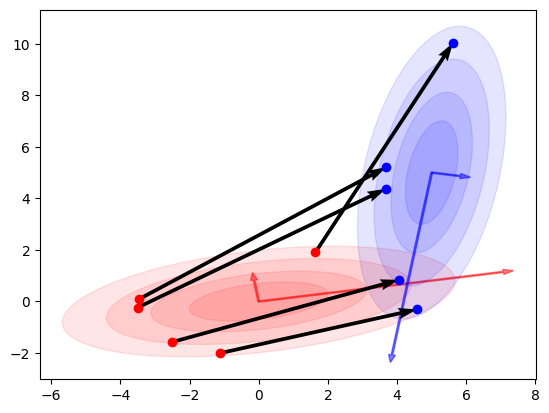

In [113]:
gaussian1=gaussian_mixture_distribution(means=jnp.array([[0,0]]),sigmas=jnp.array([[[7,1],[1,1]]]))
gaussian4=gaussian_mixture_distribution(means=jnp.array([[5,5]]),sigmas=jnp.array([[[1,1],[1,7]]]))
p=plot_optimal_transport_2d_gaussians(key,gaussian1,gaussian4)

#### 1.1.3. Brenier's theorem


Let $\mathcal{P}(\Omega)$ be the space of (Borel) probability measures with support contained in $\Omega$, and $\mathcal{P}_{\text{ac}}(\Omega)$ be those with densities.


Brenier's Theorem, provides (and is not limited to) a sufficient condition ($P$ has a density) for the existence of an optimal transport from $P$ to $Q$.


Brenier's theorem also expresses the optimal transport when the sufficient conditions are met, as a function of the  

$$\varphi_0=\underset{\varphi \in L^1(P)}{\mathrm{argmin}} \int \varphi \mathrm{d} P + \int \varphi^* \mathrm{d} Q,$$

where $L^1(P)$ is the set of integrable functions with respect to $P$ and $\varphi^*$ is the convex conjugate to $\varphi$.


#### 1.1.4. The convex relaxation of the Monge problem by Kantorovitch

The optimal plan $\pi_0$ between $P$ and $Q$ is the coupling,
e.g. the element of
$$ \Pi(P,Q) := \{ \pi \in \mathcal{P}(\Omega \times \Omega) \ |  \ \pi(A\times\Omega) = P(A), \pi(\Omega\times A) = Q(A) \}$$
that minimises

$$\underset{\pi \in \Pi(P,Q)}{\mathrm{argmin}} \int \frac{1}{2}\| x - y\|_2^2 \mathrm{d} \pi(x,y) ~~~~~~~(5)$$
The 2-Wasserstein distance between $P$ and $Q$ is then
$$
\frac{1}{2}W_2^2(P,Q) := \min_{\pi \in \Pi(P,Q)} \int \frac{1}{2}\| x - y\|_2^2 \mathrm{d} \pi(x,y)=\int \frac{1}{2}\| x - y\|_2^2 \mathrm{d} \pi_0(x,y)$$


### 1.1.5. Entropic optimal transport under the quadratic cost


We regularise the problem of Equation (5) by adding a regularization term times a regularization parameter $\varepsilon$. Assume both $P$ and $Q$ have second order moments, then the following expression is defined and is called the optimal entropic plan

$$\pi_\varepsilon:=
\min_{\pi \in \Pi(P,Q)}S_\varepsilon(P,Q),$$ where $$S_\varepsilon(P,Q) := \min_{\pi \in \Pi(P,Q)} \iint \frac{1}{2}\|x-y\|_2^2 \mathrm{d} \pi(x,y) + \varepsilon D_{\mathrm{KL}}(\pi||P \otimes Q),~~~~~~~~~(7)$$
and $D_{\mathrm{KL}}$ denotes the Kullback-Leibler divergence.

The dual version of Equation (7) is based on the following property:



$$S_\varepsilon(P, Q) = \max_{\substack{f \in L^1(P)\\g \in L^1(Q)}} \int f \mathrm{d} P + \int g \mathrm{d} Q - \varepsilon \iint e^{(f(x) + g(y) - \frac{1}{2}\|x-y\|^2)/ \varepsilon}\mathrm{d} P(x)\mathrm{d} Q(y) + \varepsilon. ~~~(8)$$


The solutions in $(f_\varepsilon, g_\varepsilon)$ the solution to Equation (8(are called the **optimal entropic potentials** and the optimal entropic plan can be derived from
$(f_\varepsilon, g_\varepsilon)$ via the relation:


$$ \mathrm{d}\pi_\varepsilon(x,y) := \tilde{\pi}_\varepsilon(x,y) \mathrm{d} P(x) \mathrm{d} Q(y) := \exp((f_\varepsilon(x) + g_\varepsilon(y) - \frac{1}{2}\|x-y\|^2)/\varepsilon) \mathrm{d} P(x)\mathrm{d} Q(y)\,. $$

which implies that $$
\int \exp\left(\frac 1 \varepsilon(f_\varepsilon(x) + g_\varepsilon(y) - \frac{1}{2}\|x-y\|^2)\right) \mathrm{d} P(x)  =1 \quad \forall y \in \mathbb{R}^d ~~~~(9.1)$$
and $$
\int \exp\left(\frac 1 \varepsilon(f_\varepsilon(x) + g_\varepsilon(y) - \frac{1}{2}\|x-y\|^2)\right) \mathrm{d} Q(y)  =1 \quad \forall x \in \mathbb{R}^d\,.~~~~(9.2)
$$


Importantly if $(f_\varepsilon, g_\varepsilon)$ satisfies (9.1) and (9.2) $P \otimes Q$ almost everywhere, then $\exp((f_\varepsilon(x) + g_\varepsilon(y) - \frac{1}{2}\|x-y\|^2)/\varepsilon)$ is the $P \otimes Q$ density of the optimal entropic plan.






### 1.2 Estimation from a sample

Imagine that $P$ and $Q$ are unknown, and we have two iid samples
$X_1,\ldots,X_n\overset{i.i.d}\sim P$,
$Y_1,\ldots,Y_n\overset{i.i.d}\sim Q$,

Let denote $P_n = \frac 1n \sum_{i=1}^n \delta_{X_i}$ and $Q_n = \frac 1n \sum_{i=1}^n \delta_{Y_i}$  the corresponding empirical distributions, where $\delta_x$ is the Dirac measure in $\mathbb{x}$.

The authors define the following estimator: $$T_{\varepsilon, (n, n)}:\Omega\to\Omega,x\mapsto
T_{\varepsilon, (n, n)}(x) = \frac{\frac 1n \sum_{i=1}^n Y_i \exp\left(\frac 1 \varepsilon(g_{\varepsilon, (n,n)}(Y_i) - \frac 12 \|x -Y_i \|^2)\right)}{\frac 1n \sum_{i=1}^n \exp\left(\frac 1 \varepsilon(g_{\varepsilon, (n,n)}(Y_i) - \frac 12 \|x -Y_i \|^2)\right)}\,,
$$
where $g_{\varepsilon, (n, n)}$ is the entropic potential corresponding to $Q_n$ in the optimal entropic plan between $P_n$ and $Q_n$.





### Code

# 2. Computation of the estimator with ott-jax

### 2.1. Code for the estimator

The estimator is a function of the observations, namely $X$ and $Y$, and is tuned up by $\varepsilon$.


To code for the estimator in python, we create a python function that takes two jnparrays of the same dimension (first dimension is the sample size, second the space dimension).

Then, we  define a `PointCloud` `geometry` which contains:
* the point clouds `X` and `Y`,
* the cost function `cost_fn`,
* the entropic regularization strength `epsilon`.

The weight vectors `a` and `b`, are constants.

For the `cost_fn` parameter, we take `ott.geometry.costs.Euclidean`.

Note that we need to use the option `relative_epsilon=False` when using the computation of the cost in `ott`.

We run the sinkhorn algorithm and get as a sideproduct the values of $g_\varepsilon$ for all points of $Y$.

Then we have all the ingredients to compute the estimator.

In [108]:
def T(x,y,epsilon):
    n=x.shape[0]
    m=y.shape[0]
    a = jnp.ones(n) / n
    b = jnp.ones(m) / m
    geom = pointcloud.PointCloud(
        x=x, y=y,
        cost_fn=costs.Euclidean(),
        epsilon=epsilon,
        relative_epsilon=False
    )
    # create optimization problem
    ot_prob = linear_problem.LinearProblem(geom, a=a, b=b)

    # create sinkhorn solver
    solver = sinkhorn.Sinkhorn(ot_prob)

    # solve the OT problem
    ot_sol = solver(ot_prob)

    g=ot_sol.g
    def make_transport(y, g, epsilon):
        def transport(x):
          """
          Compute the entropic transport map T_epsilon for a point x to a distribution Y.

          Parameters:
          - x (jnp.ndarray): A single point from the source distribution.
          - y (jnp.ndarray): Target distribution points.
          - g (jnp.ndarray): Dual variable for the target distribution from Sinkhorn output.
          - epsilon (float): Regularization parameter for entropy.

          Returns:
          - jnp.ndarray: The mapped point in the target space as per entropic transport.
          """
          # Compute the squared Euclidean distances from x to each point in Y
          squared_distances = jnp.linalg.norm(x - y, axis=1) ** 2

          # Compute the weights for each y in Y
          weights = jnp.exp((g - 0.5 * squared_distances) / epsilon)

          # Compute the denominator for normalization
          normalization = jnp.sum(weights)

          # Compute the numerator, which is the weighted sum of the points in Y
          weighted_sum = jnp.dot(weights, y)

          # Calculate the transport map result as the ratio
          transport_map_result = weighted_sum / normalization
          return transport_map_result
        return transport
    transport = make_transport(y, g, epsilon)
    return vmap(transport,in_axes=0)


#### test cell

In [109]:
if test:
    gaussian1=gaussian_mixture_distribution(means=jnp.array([[0,0]]),sigmas=jnp.array([[[7,1],[1,1]]]))
    gaussian2=gaussian_mixture_distribution(means=jnp.array([[5,5]]),sigmas=jnp.array([[[1,1],[1,7]]]))
    key = jax.random.PRNGKey(0)
    key1,key2=jax.random.split(key, 2)
    x=gaussian1.sample(key1,n)
    y=gaussian2.sample(key2,n)
    epsilon=0.1
    t=T(x,y,epsilon)
    # Define the transport function
    print(t(x))


###2.2. Simulation setup

We generate two 2 dimensional normal gaussian distributions $P$ and $Q$ and draw samples of size $n$ and compare $T_{\varepsilon, (n, n)}$ to $T_0$ for $\varepsilon\in\{0.01, 0.1\}$ and $n\in\{100,1000\}$

In [110]:
def simu(n,epsilon):
    gaussian1=gaussian_mixture_distribution(means=jnp.array([[0,0]]),sigmas=jnp.array([[[7,1],[1,1]]]))
    gaussian2=gaussian_mixture_distribution(means=jnp.array([[5,5]]),sigmas=jnp.array([[[1,1],[1,7]]]))
    key = jax.random.PRNGKey(0)
    key1,key2=jax.random.split(key, 2)
    x=gaussian1.sample(key1,n)
    y=gaussian2.sample(key2,n)
    epsilon=0.1
    return(n,epsilon,T(x,y,epsilon))



def plot_optimal_and_estimated_transport_2d_gaussians(key,gaussian1,gaussian2,tepsilon):
    t=optimal_transport_gaussian(gaussian1,gaussian2)
    points=gaussian1.sample(key,20)
    fig, ax = plt.subplots()
    plot_2d_eigenvectors(ax,gaussian1,'red')
    plot_ellipsoids_and_vectors(ax, gaussian1, 'red')
    plot_2d_eigenvectors(ax,gaussian2,'blue')
    plot_ellipsoids_and_vectors(ax, gaussian2, 'blue')
    plot_points_and_transported_points(ax,points,t,'solid')
    plot_points_and_transported_points(ax,points,tepsilon,'dashed')
    return fig





In [111]:
t1=simu(100,0.1)
t2=simu(100,0.01)
t3=simu(1000,0.1)
t4=simu(1000,0.01)

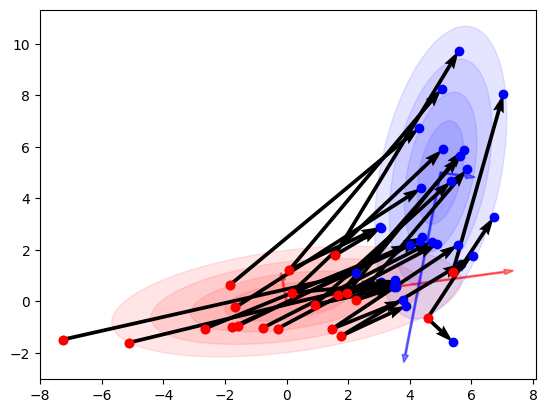

In [114]:
p=plot_optimal_and_estimated_transport_2d_gaussians(key,gaussian1,gaussian2,t1[2])

***